In [5]:
# For reading, visualizing, and preprocessing data
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
# from sklear.prepressing import Imputer
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

In [6]:
file = Path('../wl/df_all.csv')
s_path = Path('../Data/df_all_2019_2020.csv')
df_all_2019_2020 = pd.read_csv(file, parse_dates=True, infer_datetime_format=True)
df_all_2019_2020 = df_all_2019_2020.loc[(df_all_2019_2020['date'] >= '2010-08-31') & (df_all_2019_2020['date'] < '2020-03-01')]
df_all_2019_2020 = df_all_2019_2020.round(decimals=2)
df_all_2019_2020['change'] = df_all_2019_2020['price'].pct_change()
df_all_2019_2020 = df_all_2019_2020.dropna(subset=['change'])
df_all_2019_2020.head()


,date,price,uup,gdp,prod,vader,textblob_polarity,change
3045,2010-09-01,73.91,23.19,99.65,5562.00,0.26,-0.00,0.027670
3046,2010-09-02,75.02,23.17,99.65,5563.03,0.25,-0.01,0.015018
3047,2010-09-03,74.60,23.05,99.66,5564.07,0.25,-0.01,-0.005599
3048,2010-09-04,74.47,23.11,99.66,5565.10,0.24,-0.02,-0.001743
3049,2010-09-05,74.34,23.18,99.66,5566.13,0.23,-0.02,-0.001746


In [7]:
df_all_2019_2020.loc[df_all_2019_2020['change'] < 0, 'up/down'] = 0 
df_all_2019_2020.loc[df_all_2019_2020['change'] >= 0, 'up/down'] = 1
# df_all_2019_2020.loc[df_all_2019_2020['change'] == 0, 'up/down'] = 0
df_all_2019_2020.drop(columns=['price','change'], inplace=True)
df_all_2019_2020['up/down']= df_all_2019_2020['up/down'].astype(int)
df_all_2019_2020.head()

,date,uup,gdp,prod,vader,textblob_polarity,up/down
3045,2010-09-01,23.19,99.65,5562.00,0.26,-0.00,1
3046,2010-09-02,23.17,99.65,5563.03,0.25,-0.01,1
3047,2010-09-03,23.05,99.66,5564.07,0.25,-0.01,0
3048,2010-09-04,23.11,99.66,5565.10,0.24,-0.02,0
3049,2010-09-05,23.18,99.66,5566.13,0.23,-0.02,0


In [11]:
# Numpy array to pandas dataframe
X = df_all_2019_2020.drop(columns = ['up/down', 'date'])
y = df_all_2019_2020['up/down']


In [12]:
# creat train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,
                                                    random_state = 1000)


In [40]:
# Create list of tuples with classifier label and classifier object
classifiers = {}
classifiers.update({"LDA": LinearDiscriminantAnalysis()})
classifiers.update({"QDA": QuadraticDiscriminantAnalysis()})
classifiers.update({"AdaBoost": AdaBoostClassifier()})
classifiers.update({"Bagging": BaggingClassifier()})
classifiers.update({"Extra Trees Ensemble": ExtraTreesClassifier()})
classifiers.update({"Gradient Boosting": GradientBoostingClassifier()})
classifiers.update({"Random Forest": RandomForestClassifier()})
classifiers.update({"Ridge": RidgeClassifier()})
classifiers.update({"SGD": SGDClassifier()})
classifiers.update({"BNB": BernoulliNB()})
classifiers.update({"GNB": GaussianNB()})
classifiers.update({"KNN": KNeighborsClassifier()})
classifiers.update({"MLP": MLPClassifier()})
classifiers.update({"LSVC": LinearSVC()})
classifiers.update({"NuSVC": NuSVC()})
classifiers.update({"SVC": SVC()})
classifiers.update({"DTC": DecisionTreeClassifier()})
classifiers.update({"ETC": ExtraTreeClassifier()})

# Create dict of decision function labels
DECISION_FUNCTIONS = {"Ridge", "SGD", "LSVC", "NuSVC", "SVC"}

# Create dict for classifiers with feature_importances_ attribute
FEATURE_IMPORTANCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}

In [14]:
# Hyper-parameters
# Initiate parameter grid
parameters = {}

# Update dict with LDA
parameters.update({"LDA": {"classifier__solver": ["eigen"], 
                                         }})    # switch from svd solver to eigen

# Update dict with QDA
parameters.update({"QDA": {"classifier__reg_param":[0.01*ii for ii in range(0, 101)], 
                                         }})  # this regs the per-class covariance estimates by transfroming S2 where
                                              # S2 corresponds to the scaling attribute of a given class
# Update dict with AdaBoost
parameters.update({"AdaBoost": { 
                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "classifier__n_estimators": [200],
                                "classifier__learning_rate": [0.001, 0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1.0]
                                 }})

# Update dict with Bagging
parameters.update({"Bagging": { 
                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "classifier__n_estimators": [200],
                                "classifier__max_features": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                "classifier__n_jobs": [-1] # using all processors, 1 none running in parallel
                                }})

# Update dict with Gradient Boosting
parameters.update({"Gradient Boosting": { 
                                        "classifier__learning_rate":[0.15,0.1,0.05,0.01,0.005,0.001], 
                                        "classifier__n_estimators": [200],
                                        "classifier__max_depth": [2,3,4,5,6],
                                        "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                        "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                        "classifier__max_features": ["auto", "sqrt", "log2"],
                                        "classifier__subsample": [0.8, 0.9, 1]
                                         }})


# Update dict with Extra Trees
parameters.update({"Extra Trees Ensemble": { 
                                            "classifier__n_estimators": [200],
                                            "classifier__class_weight": [None, "balanced"],
                                            "classifier__max_features": ["auto", "sqrt", "log2"],
                                            "classifier__max_depth" : [3, 4, 5, 6, 7, 8],
                                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                            "classifier__criterion" :["gini", "entropy"]     ,
                                            "classifier__n_jobs": [-1]
                                             }})


# Update dict with Random Forest Parameters
parameters.update({"Random Forest": { 
                                    "classifier__n_estimators": [200],
                                    "classifier__class_weight": [None, "balanced"],
                                    "classifier__max_features": ["auto", "sqrt", "log2"],
                                    "classifier__max_depth" : [3, 4, 5, 6, 7, 8],
                                    "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                    "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                    "classifier__criterion" :["gini", "entropy"]     ,
                                    "classifier__n_jobs": [-1]
                                     }})

# Update dict with Ridge
parameters.update({"Ridge": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})

# Update dict with SGD Classifier
parameters.update({"SGD": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0],
                            "classifier__penalty": ["l1", "l2"],
                            "classifier__n_jobs": [-1]
                             }})


# Update dict with BernoulliNB Classifier
parameters.update({"BNB": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})

# Update dict with GaussianNB Classifier
parameters.update({"GNB": { 
                            "classifier__var_smoothing": [1e-9, 1e-8,1e-7, 1e-6, 1e-5]
                             }})

# Update dict with K Nearest Neighbors Classifier
parameters.update({"KNN": { 
                            "classifier__n_neighbors": list(range(1,31)),
                            "classifier__p": [1, 2, 3, 4, 5],
                            "classifier__leaf_size": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                            "classifier__n_jobs": [-1]
                             }})

# Update dict with MLPClassifier
parameters.update({"MLP": { 
                            "classifier__hidden_layer_sizes": [(5), (10), (5,5), (10,10), (5,5,5), (10,10,10)],
                            "classifier__activation": ["identity", "logistic", "tanh", "relu"],
                            "classifier__learning_rate": ["constant", "invscaling", "adaptive"],
                            "classifier__max_iter": [100, 200, 300, 500, 1000, 2000],
                            "classifier__alpha": list(10.0 ** -np.arange(1, 10)),
                             }})

parameters.update({"LSVC": { 
                            "classifier__penalty": ["l2"],
                            "classifier__C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100]
                             }})

parameters.update({"NuSVC": { 
                            "classifier__nu": [0.25, 0.50, 0.75],
                            "classifier__kernel": ["linear", "rbf", "poly"],
                            "classifier__degree": [1,2,3,4,5,6],
                             }})

parameters.update({"SVC": { 
                            "classifier__kernel": ["linear", "rbf", "poly"],
                            "classifier__gamma": ["auto"],
                            "classifier__C": [0.1, 0.5, 1, 5, 10, 50, 100],
                            "classifier__degree": [1, 2, 3, 4, 5, 6]
                             }})


# Update dict with Decision Tree Classifier
parameters.update({"DTC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["auto", "sqrt", "log2"],
                            "classifier__max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})

# Update dict with Extra Tree Classifier
parameters.update({"ETC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["auto", "sqrt", "log2"],
                            "classifier__max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})



In [42]:
# # Feature selction: remove highly correlated features
# # Filter Method: Spearman's Cross Correlation > 0.95
# # Make correlation matrix
# corr_matrix = X_train.corr(method = "spearman").abs()

# # Draw the heatmap
# sns.set(font_scale = 1.0)
# f, ax = plt.subplots(figsize=(8, 5))
# sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
# f.tight_layout()
# # plt.savefig("correlation_matrix.png", dpi = 1080)

# # Select upper triangle of matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# # Drop features
# X_train = X_train.drop(to_drop, axis = 1)
# X_test = X_test.drop(to_drop, axis = 1)

In [16]:
# # Tuning a classifer to use with RFECV

# Define classifier to use as the base of the recursive feature elimination algorithm
selected_classifier = "Random Forest"
classifier = classifiers[selected_classifier]

# Tune classifier (Took = 4.8 minutes)
    
# Scale features via Z-score normalization
scaler = StandardScaler()

# Define steps in pipeline
steps = [("scaler", scaler), ("classifier", classifier)]

# Initialize Pipeline object
pipeline = Pipeline(steps = steps)

# Define parameter grid
param_grid = parameters[selected_classifier]

# Initialize GridSearch object
gscv = GridSearchCV(pipeline, param_grid, cv = 2, n_jobs= -1, verbose = 1, scoring = "roc_auc")
# removed cv = 5 from original code
                  
# Fit gscv
print(f"Now tuning {selected_classifier}. Go grab a beer or something.")

# gscv.fit(df_min_max_scale, np.ravel(y_train))
gscv.fit(X_train, y_train)

# Get best parameters and score
best_params = gscv.best_params_
best_score = gscv.best_score_
        
# Update classifier parameters
tuned_params = {item[12:]: best_params[item] for item in best_params}
classifier.set_params(**tuned_params)


Now tuning Random Forest. Go grab a beer or something.
Fitting 2 folds for each of 1152 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed:  3.9min finished


RandomForestClassifier(criterion='entropy', max_depth=8, max_features='log2',
                       min_samples_leaf=0.005, min_samples_split=0.005,
                       n_estimators=200, n_jobs=-1)

In [17]:
# #Custom pipline object to use with RFECV
# Select Features using RFECV
class PipelineRFE(Pipeline):
    # Source: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self


In [18]:
# # Feature Selection: Recursive feature selction with cross validation
# Define pipeline for RFECV
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)

# Initialize RFECV object
feature_selector = RFECV(pipe, cv = 2, step = 1, scoring = "roc_auc", verbose = 1)

# Fit RFECV
feature_selector.fit(X_train, y_train)

# Get selected features
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.


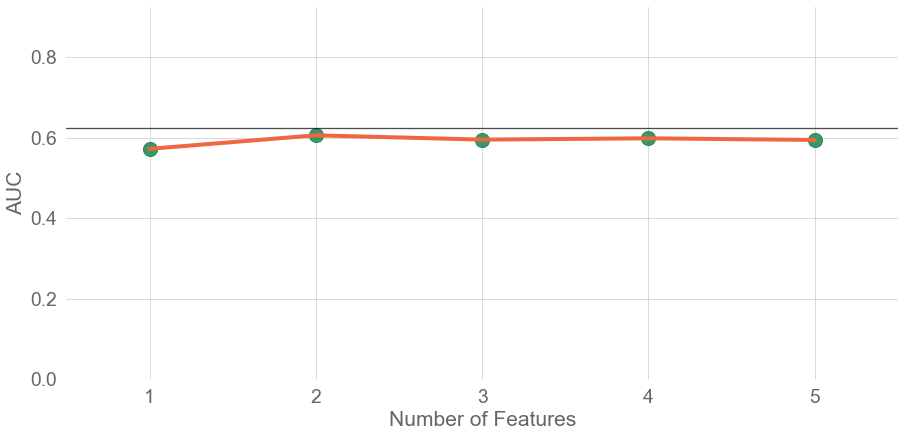

In [19]:
# # PERFORMANCE CURVE

# Get Performance Data
performance_curve = {"Number of Features": list(range(1, len(feature_names) + 1)),
                    "AUC": feature_selector.grid_scores_}
performance_curve = pd.DataFrame(performance_curve)

# Performance vs Number of Features
# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})
colors = sns.color_palette("RdYlGn", 20)
line_color = colors[3]
marker_colors = colors[-1]

# Plot
f, ax = plt.subplots(figsize=(13, 6.5))
sns.lineplot(x = "Number of Features", y = "AUC", data = performance_curve,
             color = line_color, lw = 4, ax = ax)
sns.regplot(x = performance_curve["Number of Features"], y = performance_curve["AUC"],
            color = marker_colors, fit_reg = False, scatter_kws = {"s": 200}, ax = ax)

# Axes limits
plt.xlim(0.5, len(feature_names)+0.5)
plt.ylim(0.0, 0.925)

# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0.625, color = 'black', linewidth = 1.3, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# # Save Figure
# plt.savefig("performance_curve.png", dpi = 1080)


In [20]:
# # FEATURE SELECTION: RECURSIVE FEATURE SELECTION

# Define pipeline for RFECV
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)

# Initialize RFE object
feature_selector = RFE(pipe, n_features_to_select = 2, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train, y_train)

# Get selected features labels
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.


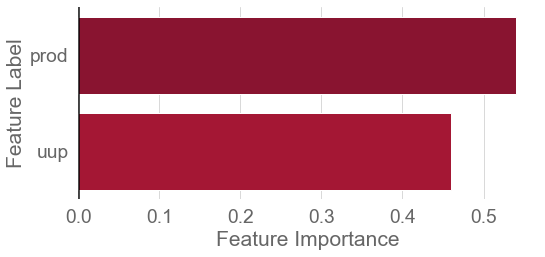

In [33]:
# # VUSUALIZING SELECTED FEATURE IMPORTANCE

# Get selected features data set
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Train classifier
classifier.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame(selected_features, columns = ["Feature Label"])
feature_importance["Feature Importance"] = classifier.feature_importances_

# Sort by feature importance
feature_importance = feature_importance.sort_values(by="Feature Importance", ascending=False)

# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

# Set figure size and create barplot
f, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x = "Feature Importance", y = "Feature Label",
            palette = reversed(sns.color_palette('YlOrRd', 15)),  data = feature_importance)

# Generate a bolded horizontal line at y = 0
ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
# plt.savefig("feature_importance.png", dpi = 1080)


In [34]:
# # CLASSIFIER TUNING AND EVALUATION

# Initialize dictionary to store results
results = {}
crs = []
# Tune and evaluate classifiers
for classifier_label, classifier in classifiers.items():
    # Print message to user
    print(f"Now tuning {classifier_label}.")
    
    # Scale features via Z-score normalization
    scaler = StandardScaler()
    
    # Define steps in pipeline
    steps = [("scaler", scaler), ("classifier", classifier)]
    
    # Initialize Pipeline object
    pipeline = Pipeline(steps = steps)
      
    # Define parameter grid
    param_grid = parameters[classifier_label]
    
    # Initialize GridSearch object
    gscv = GridSearchCV(pipeline, param_grid, cv = 2,  n_jobs= -1, verbose = 1, scoring = "roc_auc")
                      
    # Fit gscv
    gscv.fit(X_train, y_train)  
    
    # Get best parameters and score
    best_params = gscv.best_params_
    best_score = gscv.best_score_
    
    # Update classifier parameters and define new pipeline with tuned classifier
    tuned_params = {item[12:]: best_params[item] for item in best_params}
    classifier.set_params(**tuned_params)
    
    # Make predictions
    if classifier_label in DECISION_FUNCTIONS:
        y_pred = gscv.decision_function(X_test)
    else:
        y_pred = gscv.predict_proba(X_test)[:,1]
    
    # Evaluate model
    auc = metrics.roc_auc_score(y_test, y_pred)
    
    # Print Classification Report
    preds = gscv.predict(X_test)
    
    print(classifier_label)
    print(classification_report(y_test, preds))
    cr = classification_report(y_test, preds)
    crs.append(cr)
    
    # Save results
    result = {"Classifier": gscv,
              "Best Parameters": best_params,
              "Training AUC": best_score,
              "Test AUC": auc}
    
    results.update({classifier_label: result})

Now tuning LDA.
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


LDA
              precision    recall  f1-score   support

           0       0.53      0.25      0.34       361
           1       0.48      0.75      0.59       333

    accuracy                           0.49       694
   macro avg       0.50      0.50      0.47       694
weighted avg       0.50      0.49      0.46       694

Now tuning QDA.
Fitting 2 folds for each of 101 candidates, totalling 202 fits


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 202 out of 202 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


QDA
              precision    recall  f1-score   support

           0       0.54      0.26      0.35       361
           1       0.49      0.76      0.59       333

    accuracy                           0.50       694
   macro avg       0.51      0.51      0.47       694
weighted avg       0.51      0.50      0.47       694

Now tuning AdaBoost.
Fitting 2 folds for each of 40 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   15.8s finished


AdaBoost
              precision    recall  f1-score   support

           0       0.64      0.61      0.62       361
           1       0.60      0.63      0.61       333

    accuracy                           0.62       694
   macro avg       0.62      0.62      0.62       694
weighted avg       0.62      0.62      0.62       694

Now tuning Bagging.
Fitting 2 folds for each of 45 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.6s finished


Bagging
              precision    recall  f1-score   support

           0       0.57      0.32      0.41       361
           1       0.50      0.74      0.60       333

    accuracy                           0.52       694
   macro avg       0.54      0.53      0.50       694
weighted avg       0.54      0.52      0.50       694

Now tuning Extra Trees Ensemble.
Fitting 2 folds for each of 1152 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed:  2.6min finished


Extra Trees Ensemble
              precision    recall  f1-score   support

           0       0.57      0.45      0.50       361
           1       0.52      0.64      0.57       333

    accuracy                           0.54       694
   macro avg       0.55      0.54      0.54       694
weighted avg       0.55      0.54      0.54       694

Now tuning Gradient Boosting.
Fitting 2 folds for each of 4320 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed: 10.7min finished


Gradient Boosting
              precision    recall  f1-score   support

           0       0.59      0.55      0.57       361
           1       0.55      0.59      0.57       333

    accuracy                           0.57       694
   macro avg       0.57      0.57      0.57       694
weighted avg       0.57      0.57      0.57       694

Now tuning Random Forest.
Fitting 2 folds for each of 1152 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed:  3.5min finished


Random Forest
              precision    recall  f1-score   support

           0       0.58      0.50      0.54       361
           1       0.53      0.60      0.56       333

    accuracy                           0.55       694
   macro avg       0.55      0.55      0.55       694
weighted avg       0.56      0.55      0.55       694

Now tuning Ridge.
Fitting 2 folds for each of 11 candidates, totalling 22 fits
Ridge
              precision    recall  f1-score   support

           0       0.53      0.25      0.34       361
           1       0.48      0.75      0.59       333

    accuracy                           0.49       694
   macro avg       0.50      0.50      0.47       694
weighted avg       0.50      0.49      0.46       694

Now tuning SGD.
Fitting 2 folds for each of 22 candidates, totalling 44 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


SGD
              precision    recall  f1-score   support

           0       0.50      0.14      0.22       361
           1       0.48      0.85      0.61       333

    accuracy                           0.48       694
   macro avg       0.49      0.49      0.41       694
weighted avg       0.49      0.48      0.41       694

Now tuning BNB.
Fitting 2 folds for each of 11 candidates, totalling 22 fits
BNB
              precision    recall  f1-score   support

           0       0.52      0.50      0.51       361
           1       0.48      0.49      0.49       333

    accuracy                           0.50       694
   macro avg       0.50      0.50      0.50       694
weighted avg       0.50      0.50      0.50       694

Now tuning GNB.
Fitting 2 folds for each of 5 candidates, totalling 10 fits
GNB

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



              precision    recall  f1-score   support

           0       0.54      0.38      0.44       361
           1       0.49      0.65      0.56       333

    accuracy                           0.51       694
   macro avg       0.52      0.52      0.50       694
weighted avg       0.52      0.51      0.50       694

Now tuning KNN.
Fitting 2 folds for each of 1500 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   37.5s finished


KNN
              precision    recall  f1-score   support

           0       0.60      0.81      0.69       361
           1       0.67      0.41      0.51       333

    accuracy                           0.62       694
   macro avg       0.63      0.61      0.60       694
weighted avg       0.63      0.62      0.60       694

Now tuning MLP.
Fitting 2 folds for each of 3888 candidates, totalling 7776 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 7776 out of 7776 | elapsed:  6.6min finished


MLP
              precision    recall  f1-score   support

           0       0.54      0.22      0.32       361
           1       0.48      0.79      0.60       333

    accuracy                           0.50       694
   macro avg       0.51      0.51      0.46       694
weighted avg       0.51      0.50      0.45       694

Now tuning LSVC.
Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.1s finished
C:\Users\brett\anaconda3\envs\dev\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


LSVC
              precision    recall  f1-score   support

           0       0.53      0.75      0.62       361
           1       0.50      0.27      0.35       333

    accuracy                           0.52       694
   macro avg       0.51      0.51      0.49       694
weighted avg       0.51      0.52      0.49       694

Now tuning NuSVC.
Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    3.1s finished


NuSVC
              precision    recall  f1-score   support

           0       0.55      0.52      0.54       361
           1       0.51      0.54      0.53       333

    accuracy                           0.53       694
   macro avg       0.53      0.53      0.53       694
weighted avg       0.53      0.53      0.53       694

Now tuning SVC.
Fitting 2 folds for each of 126 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 229 out of 252 | elapsed:   10.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed:   20.8s finished


SVC
              precision    recall  f1-score   support

           0       0.53      0.39      0.45       361
           1       0.48      0.62      0.54       333

    accuracy                           0.50       694
   macro avg       0.50      0.50      0.50       694
weighted avg       0.51      0.50      0.49       694

Now tuning DTC.
Fitting 2 folds for each of 3072 candidates, totalling 6144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 3000 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 5800 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 6144 out of 6144 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


DTC
              precision    recall  f1-score   support

           0       0.53      0.44      0.48       361
           1       0.48      0.57      0.52       333

    accuracy                           0.50       694
   macro avg       0.51      0.51      0.50       694
weighted avg       0.51      0.50      0.50       694

Now tuning ETC.
Fitting 2 folds for each of 3072 candidates, totalling 6144 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 5640 tasks      | elapsed:   14.9s


ETC
              precision    recall  f1-score   support

           0       0.58      0.55      0.56       361
           1       0.54      0.57      0.56       333

    accuracy                           0.56       694
   macro avg       0.56      0.56      0.56       694
weighted avg       0.56      0.56      0.56       694



[Parallel(n_jobs=-1)]: Done 6144 out of 6144 | elapsed:   15.9s finished


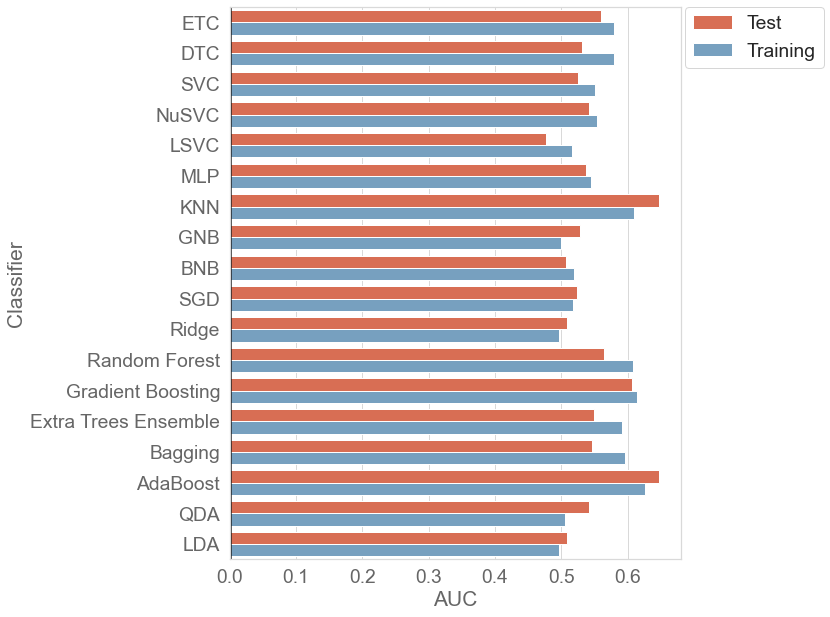

In [50]:
# # VISUALING RESULTS

# Initialize auc_score dictionary
auc_scores = {
              "Classifier": [],
              "AUC": [],
              "AUC Type": []
              }

# Get AUC scores into dictionary
for classifier_label in results:
    auc_scores.update({"Classifier": [classifier_label] + auc_scores["Classifier"],
                       "AUC": [results[classifier_label]["Training AUC"]] + auc_scores["AUC"],
                       "AUC Type": ["Training"] + auc_scores["AUC Type"]})
    
    auc_scores.update({"Classifier": [classifier_label] + auc_scores["Classifier"],
                       "AUC": [results[classifier_label]["Test AUC"]] + auc_scores["AUC"],
                       "AUC Type": ["Test"] + auc_scores["AUC Type"]})

# Dictionary to PandasDataFrame
auc_scores = pd.DataFrame(auc_scores)

# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

    
# Colors
training_color = sns.color_palette("RdYlBu", 10)[1]
test_color = sns.color_palette("RdYlBu", 10)[-2]
colors = [training_color, test_color]

# Set figure size and create barplot
f, ax = plt.subplots(figsize=(12, 9))

sns.barplot(x="AUC", y="Classifier", hue="AUC Type", palette = colors,
            data=auc_scores)

plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

# Generate a bolded horizontal line at y = 0
ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

# # Turn frame off
# ax.set_frame_on(True)

# Tight layout
plt.tight_layout()

# # Save Figure
# plt.savefig("AUC Scores.png", dpi = 1080)

In [36]:
df_auc = auc_scores.loc[(auc_scores['AUC Type']) == 'Test']
df_auc = df_auc.nlargest(5, 'AUC')
df_auc

,Classifier,AUC,AUC Type
30,AdaBoost,0.647917,Test
12,KNN,0.647064,Test
24,Gradient Boosting,0.606170,Test
22,Random Forest,0.564897,Test
0,ETC,0.560696,Test


In [37]:
results["AdaBoost"]['Best Parameters']

{'classifier__base_estimator': DecisionTreeClassifier(max_depth=5),
 'classifier__learning_rate': 0.25,
 'classifier__n_estimators': 200}

In [38]:
results["KNN"]['Best Parameters']

{'classifier__leaf_size': 5,
 'classifier__n_jobs': -1,
 'classifier__n_neighbors': 2,
 'classifier__p': 1}

In [39]:
results["Gradient Boosting"]['Best Parameters']

{'classifier__learning_rate': 0.15,
 'classifier__max_depth': 6,
 'classifier__max_features': 'log2',
 'classifier__min_samples_leaf': 0.005,
 'classifier__min_samples_split': 0.01,
 'classifier__n_estimators': 200,
 'classifier__subsample': 1}